## 단일 에이전트로 ChatGPT 만들어 보기
웹검색 에이전트

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

### 시스템 메시지를 보강한 챗봇

In [2]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from datetime import datetime
from langchain_community.tools.tavily_search import TavilySearchResults

system_prompt = f"""
You are a helpful AI Assistant that can use web search tool(tavily ai api).
You should always answer in same language as user's ask.
When use ask about the information that you can't answer, you should call the web search tool.

web search tool is useful when:
- real-time info
- local specialized info
- metric related info

you should use web search tool with the guideline below:
- Extract the user query's intent and rephrase the prompt into appropriate search query
- web search tool(Tavily AI API) can deal with sentence query. 
you don't need to limit your querying ability to generating keyword only query.
- Today is {datetime.now().strftime("%Y-%m-%d")}
"""

prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt),
    HumanMessagePromptTemplate.from_template("{input}")
])


# LLM 초기화 시 시스템 프롬프트 설정
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

search = TavilySearchResults(max_results=5)

tools = [search]
llm_with_tools = llm.bind_tools(tools)

# 프롬프트 체인 생성
chain = prompt | llm_with_tools

/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_51567/3522539332.py:36: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search = TavilySearchResults(max_results=5)


In [3]:
result = chain.invoke({"input": "대한민국 축구국가대표팀 명단 알려줘"})
print(result)

content='' additional_kwargs={'tool_calls': [{'id': 'call_TOisHUOe5fNRmuXKpavvse0L', 'function': {'arguments': '{"query":"대한민국 축구국가대표팀 2025 명단"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 232, 'total_tokens': 262, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--d2ec608e-0cfa-42bd-ae50-aa8687784590-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '대한민국 축구국가대표팀 2025 명단'}, 'id': 'call_TOisHUOe5fNRmuXKpavvse0L', 'type': 'tool_call'}] usage_metadata={'input_tokens': 232, 'output_tokens': 30, 'total_tokens': 262, 'input_token_details': {'audio': 0, 'cache_read': 0}, '

In [4]:
print(result.additional_kwargs)

{'tool_calls': [{'id': 'call_TOisHUOe5fNRmuXKpavvse0L', 'function': {'arguments': '{"query":"대한민국 축구국가대표팀 2025 명단"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}


### 그래프 생성

In [5]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [chain.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

# 도구 노드 추가
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# 조건부 엣지 추가
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# 도구 호출 후 채팅봇으로 돌아가는 엣지 추가
graph_builder.add_edge("tools", "chatbot")

# 시작점 설정
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

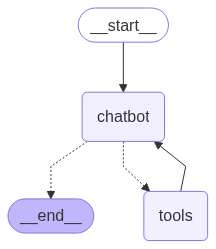

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# The config is the **second positional argument** to stream() or invoke()!
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", input("User: "))]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

대한민국 축구 국가대표팀 명단 알려줘
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_P0TfQPl1EiOp9i24BVzesBjt)
 Call ID: call_P0TfQPl1EiOp9i24BVzesBjt
  Args:
    query: 대한민국 축구 국가대표팀 2025 명단
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "대한민국 축구 국가대표팀 2025 시즌", "url": "https://ko.wikipedia.org/wiki/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD_%EC%B6%95%EA%B5%AC_%EA%B5%AD%EA%B0%80%EB%8C%80%ED%91%9C%ED%8C%80_2025_%EC%8B%9C%EC%A6%8C", "content": "대한민국 축구 국가대표팀 2025 시즌은 대한민국 축구 국가대표팀이 2025년에 ... 홍명보. 최우수 선수: 김진규 (대한민국). 부심: 미하라 준 (일본) 와타나베 고타", "score": 0.87706697}, {"title": "2025 EAFF E-1 풋볼 챔피언십 대한민국 축구국가대표팀 ...", "url": "https://www.facebook.com/KoreaFootballTeam/posts/2025-eaff-e-1-%ED%92%8B%EB%B3%BC-%EC%B1%94%ED%94%BC%EC%96%B8%EC%8B%AD-%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5

### 커스텀 툴 설정을 통한 도구 통제성 향상

In [8]:
from langchain_core.tools import tool
from tavily import TavilyClient

@tool
def search_news(keyword: str) -> str:
    """Collect recent news for the given query. """
    tavily_client = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])
    search_results = tavily_client.search(query=keyword, topic="news", days = 30)
    return search_results

In [9]:
# LLM 초기화 시 시스템 프롬프트 설정
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

tools = [search_news]
llm_with_tools = llm.bind_tools(tools)

In [10]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

# 도구 노드 추가
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# 조건부 엣지 추가
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# 도구 호출 후 채팅봇으로 돌아가는 엣지 추가
graph_builder.add_edge("tools", "chatbot")

# 시작점 설정
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

In [11]:
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", input("User: "))]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

지금 상영하고 있는 영화중 인기가 가장 많은 것은?
================================== Ai Message ==================================
Tool Calls:
  search_news (call_7nWw1Uo97h57wRrA1k63MSPN)
 Call ID: call_7nWw1Uo97h57wRrA1k63MSPN
  Args:
    keyword: 현재 상영 중인 인기 영화
================================= Tool Message =================================
Name: search_news

{"query": "현재 상영 중인 인기 영화", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ign.com/articles/jurassic-world-rebirth-gets-off-to-big-box-office-start-f1-now-apples-highest-grossing-movie", "title": "Jurassic World Rebirth Gets Off to Big Box Office Start, F1 Now Apple's Highest-Grossing Movie - IGN", "score": 0.22479525, "published_date": "Sun, 06 Jul 2025 21:01:20 GMT", "content": "Jurassic World Rebirth Gets Off to Big Box Office Start, F1 Now Apple's Highest-Grossing Movie - IGN Jurassic World Rebirth Gets Off to Big Box O